## RNNを使った為替(FX)予測

[以前の記事](/ml/lec/text/lstm_stock/)で株価の予測をしてみたので、同じ時系列データが取得しやすい為替について予測をしてみます。
株価と同様、変動要因は様々あるので、ニューラルネットのモデルだけで予測するのは難しいと思いますが、Kerasの練習だと思ってやってみます。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/tree/master/ml/lec/text/lstm_fx/lstm_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/tree/master/ml/lec/text/lstm_fx/lstm_nb.ipynb)

### 筆者の環境
筆者のOSはmacOSです。LinuxやUnixのコマンドとはオプションが異なります。

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6020


In [2]:
!python -V

Python 3.7.3


基本的なライブラリとkerasをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('tensorflow version : ', tf.__version__)
print('keras version : ', keras.__version__)

matplotlib version : 3.0.3
scipy version : 1.4.1
numpy version : 1.19.4
tensorflow version :  2.4.0
keras version :  2.4.0


## データの取得

今回はUSD/JPY, EUR/USD, GBP/USDの３通貨ペア(日足)について予測を行います。
データは、以下のサイトからダウンロードさせていただきました。

- https://www.central-tanshifx.com/market/finder/popn-csv-download.html


## データの確認
まず最初にUSDJPYのデータを見てみます。

In [4]:
!ls ./data/ 

01_USDJPY_D.csv 03_EURUSD_D.csv 05_GBPUSD_D.csv eurusd_utf8.csv gbpusd_utf8.csv usdjpy_utf8.csv


In [5]:
%%bash
head ./data/01_USDJPY_D.csv

"�ʉ݃y�A","���t","�n�l","���l","���l","�I�l"
"1","2021/01/07",103.001,103.958,102.950,103.814
"1","2021/01/06",102.697,103.445,102.592,103.069
"1","2021/01/05",103.054,103.192,102.605,102.719
"1","2021/01/04",103.083,103.316,102.713,103.152
"1","2020/12/31",103.128,103.317,102.995,103.292
"1","2020/12/30",103.530,103.584,102.962,103.211
"1","2020/12/29",103.722,103.806,103.463,103.531
"1","2020/12/28",103.496,103.899,103.404,103.788
"1","2020/12/25",103.615,103.656,103.486,103.585


In [6]:
%%bash
nkf --guess ./data/01_USDJPY_D.csv

Shift_JIS (LF)


utf-8に直します。

In [7]:
%%bash
nkf -w ./data/01_USDJPY_D.csv > ./data/usdjpy_utf8.csv
nkf -w ./data/03_EURUSD_D.csv > ./data/eurusd_utf8.csv
nkf -w ./data/05_GBPUSD_D.csv > ./data/gbpusd_utf8.csv

文字コードがshift-jisになっているので、utf-8に直します。

In [8]:
%%bash
head ./data/usdjpy_utf8.csv

"通貨ペア","日付","始値","高値","安値","終値"
"1","2021/01/07",103.001,103.958,102.950,103.814
"1","2021/01/06",102.697,103.445,102.592,103.069
"1","2021/01/05",103.054,103.192,102.605,102.719
"1","2021/01/04",103.083,103.316,102.713,103.152
"1","2020/12/31",103.128,103.317,102.995,103.292
"1","2020/12/30",103.530,103.584,102.962,103.211
"1","2020/12/29",103.722,103.806,103.463,103.531
"1","2020/12/28",103.496,103.899,103.404,103.788
"1","2020/12/25",103.615,103.656,103.486,103.585


問題ないようなので、pandasで読み込みます。

In [9]:
df_u = pd.read_csv('./data/usdjpy_utf8.csv')
df_e = pd.read_csv('./data/eurusd_utf8.csv')
df_g = pd.read_csv('./data/gbpusd_utf8.csv')

In [10]:
df_u.head()

,通貨ペア,日付,始値,高値,安値,終値
0,1,2021/01/07,103.001,103.958,102.950,103.814
1,1,2021/01/06,102.697,103.445,102.592,103.069
2,1,2021/01/05,103.054,103.192,102.605,102.719
3,1,2021/01/04,103.083,103.316,102.713,103.152
4,1,2020/12/31,103.128,103.317,102.995,103.292


In [11]:
df_u.tail()

,通貨ペア,日付,始値,高値,安値,終値
195,1,2020/04/08,108.775,109.099,108.500,108.845
196,1,2020/04/07,109.188,109.263,108.670,108.796
197,1,2020/04/06,108.388,109.382,108.388,109.200
198,1,2020/04/03,107.800,108.678,107.781,108.460
199,1,2020/04/02,107.119,108.091,107.011,107.857


日付でソートします。

In [12]:
df_u.sort_values(by=["日付"], ascending=True, inplace=True)
df_e.sort_values(by=["日付"], ascending=True, inplace=True)
df_g.sort_values(by=["日付"], ascending=True, inplace=True)

### データのグラフ化

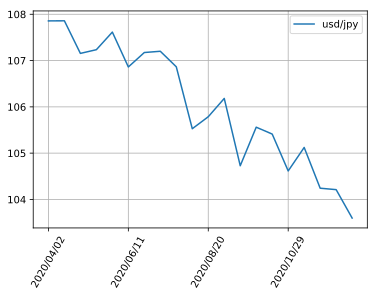

In [13]:
ticks = 10
xticks = ticks * 5 

plt.plot(df_u['日付'][::ticks], df_u['終値'][::ticks], label='usd/jpy')
plt.grid()
plt.legend()
plt.xticks(df_u['日付'][::xticks], rotation=60)
plt.show()

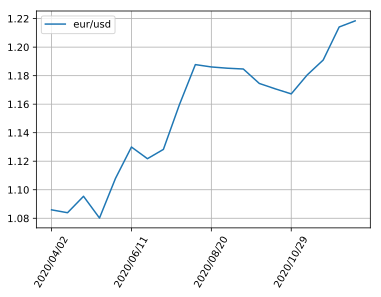

In [14]:
plt.plot(df_e['日付'][::ticks], df_e['終値'][::ticks], label='eur/usd')
plt.grid()
plt.legend()
plt.xticks(df_u['日付'][::xticks], rotation=60)
plt.show()

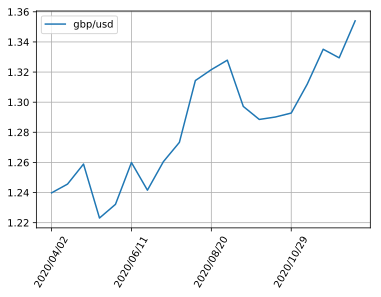

In [15]:
plt.plot(df_g['日付'][::ticks], df_g['終値'][::ticks], label='gbp/usd')
plt.grid()
plt.legend()
plt.xticks(df_u['日付'][::xticks], rotation=60)
plt.show()

In [16]:
df_u.shape

(200, 6)

In [17]:
df_e.shape

(200, 6)

In [18]:
df_g.shape

(200, 6)

### データの整形
最初のデータを基準に、その値からの変化率を計算し、そのリストに対して学習を行います。

In [19]:
def shape_data(data_list):
  return [d / data_list[0] - 1 for d in data_list]

df_u['data_list'] = shape_data(list(df_u['終値']))
df_e['data_list'] = shape_data(list(df_e['終値']))
df_g['data_list'] = shape_data(list(df_g['終値']))

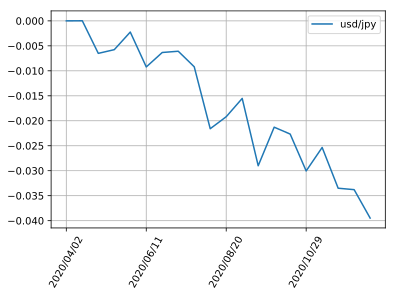

In [20]:
plt.plot(df_u['日付'][::ticks], df_u['data_list'][::ticks], label='usd/jpy')
plt.grid()
plt.legend()
plt.xticks(df_u['日付'][::xticks], rotation=60)
plt.show()

### 定数の準備

日足データとして200本あるので、二つのパートに分けて予測を行います。

In [38]:
# データとしては約四年分あるが、今回はこれを8このパートに分けて、それぞれの領域で予想を行う
TERM_PART_LIST = [0, 100, 200]

# 予測に利用するデータ数
# 75個のデータから後の25個のデータを予測する
NUM_LSTM = 75

# 中間層の数
NUM_MIDDLE = 200

# ニューラルネットのモデルの定数
batch_size = 100
epochs = 50
validation_split = 0.25

### データの準備
kerasに投入するためにデータを整えます。

In [22]:
def get_x_y_lx_ly(currency='usdjpy', term_part=0):
  if currency == 'usdjpy':
    date = np.array(df_u['日付'][TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])
    x = np.array(df_u.index.values[TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])
    y = np.array(df_u['data_list'][TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])
  
  if currency == 'eurusd':
    date = np.array(df_e['日付'][TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])
    x = np.array(df_e.index.values[TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])
    y = np.array(df_e['data_list'][TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])
 
  if currency == 'gbpusd':
    date = np.array(df_g['日付'][TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])
    x = np.array(df_g.index.values[TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])
    y = np.array(df_g['data_list'][TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])

  n = len(y) - NUM_LSTM
  l_x = np.zeros((n, NUM_LSTM))
  l_y = np.zeros((n, NUM_LSTM))
  
  for i in range(0, n):
    l_x[i] = y[i: i + NUM_LSTM]
    l_y[i] = y[i + 1: i + NUM_LSTM + 1]
  
  l_x = l_x.reshape(n, NUM_LSTM, 1)
  l_y = l_y.reshape(n, NUM_LSTM, 1)
  
  return n, date, x, y, l_x, l_y

n, date, x, y, l_x, l_y = get_x_y_lx_ly('usdjpy', 0)

In [23]:
print('shape : ', x.shape)
print('ndim : ', x.ndim)
print('data : ', x[:10])

shape :  (100,)
ndim :  1
data :  [199 198 197 196 195 194 193 192 191 190]


In [24]:
print('shape : ', y.shape)
print('ndim : ', y.ndim)
print('data : ', y[:10])

shape :  (100,)
ndim :  1
data :  [ 0.          0.00559074  0.01245167  0.00870597  0.00916028  0.0058967
  0.0050159  -0.00100133 -0.00599868 -0.0039404 ]


In [25]:
print(l_y.shape)
print(l_x.shape)

(25, 75, 1)
(25, 75, 1)


### モデルの構築
モデルの構築を定義する関数です。デフォルトではRNNとします。

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU


def build_model(model_name='RNN'):
  # LSTMニューラルネットの構築
  model = Sequential()
  
  # RNN,LSTM、GRUを選択できるようにする
  if model_name == 'RNN':
    model.add(SimpleRNN(NUM_MIDDLE, input_shape=(NUM_LSTM, 1), return_sequences=True))
  
  if model_name == 'LSTM':
    model.add(LSTM(NUM_MIDDLE, input_shape=(NUM_LSTM, 1), return_sequences=True))
  
  if model_name == 'GRU':
    model.add(GRU(NUM_MIDDLE, input_shape=(NUM_LSTM, 1), return_sequences=True))
  
  model.add(Dense(1, activation="linear"))
  model.compile(loss="mean_squared_error", optimizer="sgd")
  
  return model


# ニューラルネットを深くした（今回は使わない）
def build_model_02(): 
  
  NUM_MIDDLE_01 = 50
  NUM_MIDDLE_02 = 50
  
  # LSTMニューラルネットの構築
  model = Sequential()
  model.add(SimpleRNN(NUM_MIDDLE_01, input_shape = (NUM_LSTM, 1), return_sequences=True))
  model.add(Dropout(0.2))
  # model.add(SimpleRNN(NUM_MIDDLE_02, return_sequences=True))
  # model.add(Dropout(0.2))
  model.add(Dense(1))
  model.add(Activation("linear"))
  model.compile(loss="mean_squared_error", optimizer="sgd")
  # model.compile(loss="mse", optimizer='rmsprop')
    
  return model
  
model = build_model('RNN')

### モデルの詳細

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 75, 200)           40400     
_________________________________________________________________
dense (Dense)                (None, 75, 1)             201       
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________


In [28]:
# validation_split で最後の10％を検証用に利用します
history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)

### 損失関数の可視化
学習によって誤差が減少していく様子を可視化してみます。val_lossが増えていき、過学習になっていますね。正規化やDropOutが必要かと思います。

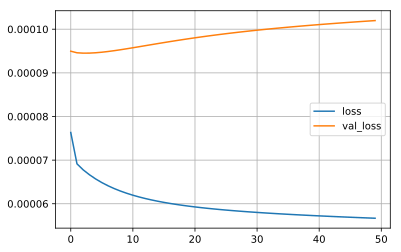

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss, label='loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
plt.grid()
plt.legend()
plt.show()

### RNNによる結果の確認
薄いオレンジに塗りつぶされた期間が予測のために利用した期間です。その期間は、実際の推移と予測が一致しています。オレンジの実線が実際の株価推移、青が予測です。

2020/04/02 - 2020/07/15 の結果


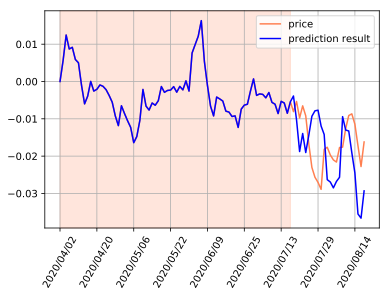

In [30]:
def plot_result():

  # 初期の入力値
  res = []
  res = np.append(res, l_x[0][0][0])
  res = np.append(res, l_y[0].reshape(-1))
  
  for i in range(0, n):
    _y = model.predict(res[- NUM_LSTM:].reshape(1, NUM_LSTM, 1))
    
    # 予測されたデータを次の予測のためのインプットデータとして利用
    res = np.append(res, _y[0][NUM_LSTM - 1][0])
  
  res = np.delete(res, -1)  
  
  plt.plot(date, y, label="price", color='coral')
  plt.plot(date, res, label="prediction result", color='blue')
  plt.xticks(date[::12], rotation=60)
  
  plt.legend()
  plt.grid()
  
  plt.axvspan(0, NUM_LSTM, color="coral", alpha=0.2)
  
  plt.show()
  
print('{} - {} の結果'.format(date[0], date[NUM_LSTM - 1]))
plot_result()

## USDJPY

usdjpyの後半の期間の予測を行います。

usdjpy :
予測期間 : 2020/08/20 - 2020/12/02 の結果


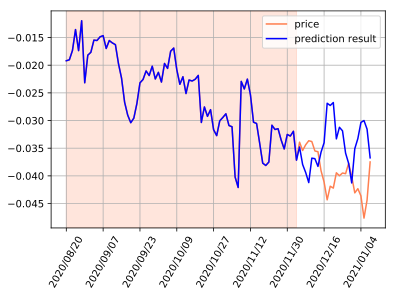

In [31]:
currency = 'usdjpy'
for term in [1]:
  n, date, x, y, l_x, l_y = get_x_y_lx_ly(currency, term)
  model = build_model('RNN')
  history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
  print('{} :'.format(currency))
  print('予測期間 : {} - {} の結果'.format(date[0], date[NUM_LSTM - 1]))
  plot_result()

## EURUSD

eurusd :
予測期間 : 2020/04/02 - 2020/07/15 の結果


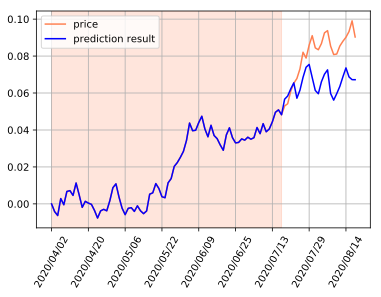

eurusd :
予測期間 : 2020/08/20 - 2020/12/02 の結果


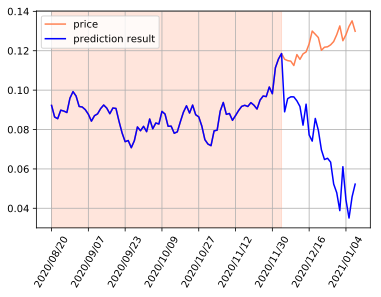

In [32]:
currency = 'eurusd'
for term in [0, 1]:
  n, date, x, y, l_x, l_y = get_x_y_lx_ly(currency, term)
  model = build_model('RNN')
  history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
  print('{} :'.format(currency))
  print('予測期間 : {} - {} の結果'.format(date[0], date[NUM_LSTM - 1]))
  plot_result()

## GBPUSD

gbpusd :
予測期間 : 2020/04/02 - 2020/07/15 の結果


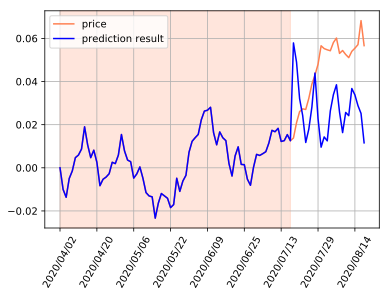

gbpusd :
予測期間 : 2020/08/20 - 2020/12/02 の結果


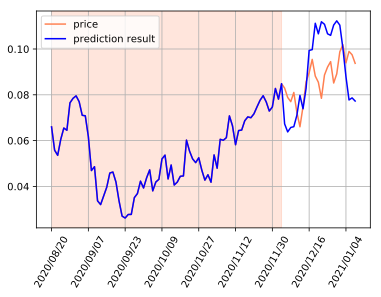

In [33]:
currency = 'gbpusd'
for term in [0, 1]:
  n, date, x, y, l_x, l_y = get_x_y_lx_ly(currency, term)
  model = build_model('RNN')
  history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
  print('{} :'.format(currency))
  print('予測期間 : {} - {} の結果'.format(date[0], date[NUM_LSTM - 1]))
  plot_result()

## GBPUSD ver2

過学習対策のためにDropoutを入れたモデルを試してみます。

gbpusd :
予測期間 : 2020/08/20 - 2020/12/02 の結果


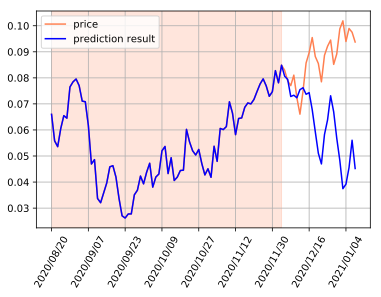

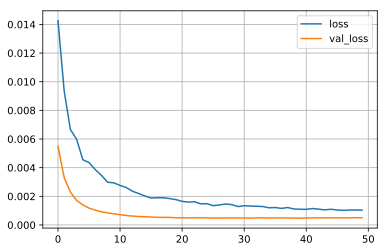

In [44]:
currency = 'gbpusd'

n, date, x, y, l_x, l_y = get_x_y_lx_ly(currency, 1)
model = build_model_02()
history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
print('{} :'.format(currency))
print('予測期間 : {} - {} の結果'.format(date[0], date[NUM_LSTM - 1]))
plot_result()
  
# 損失関数  
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss, label='loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
plt.grid()
plt.legend()
plt.show()

先ほどと違って、確かに過学習対策が効いていますが、予測はトレンドを大きく外していますね。。。

## まとめ
為替の予測は株の予測よりも構成要因が多く難しいと言われています。このような簡単なモデル予測するのは無謀だと思いますが、今回の目的はkerasに慣れることなので、ここまでにしておきます。位相が180度ずれている部分もあり、大きく外している部分もありますね･･･